In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pickle

In [31]:
dataset_path = 'RAVDESS'
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
gender_labels = ['female', 'male']

def read_ravdess_dataset(directory):
    
    file_list = []
    emotion_list = []
    gender_list = []
    
    path = os.path.join(os.getcwd(), directory)
    for folder in os.listdir(path):
        if folder == '.DS_Store':
            continue
        for filename in os.listdir(os.path.join(path, folder)):
            if filename == '.DS_Store':
                continue
            chunks = filename.split('-')
            file_path = os.path.join(path, folder, filename)
            emotion = int(chunks[2]) - 1
            gender = int(chunks[-1].split('.')[0]) % 2
            file_list.append(file_path)
            emotion_list.append(emotion)
            gender_list.append(gender)
    assert len(file_list) == len(emotion_list) == len(gender_list)
    return file_list, emotion_list, gender_list

file_list, emotion_list, gender_list = read_ravdess_dataset(dataset_path)

In [32]:
def plot_speech_examples(plot_type='waveform'):
    
    plot_files = []
    plot_emotions = []
    
    for emotion in emotion_labels[:4]:
        idx = emotion_labels.index(emotion)
        for i in range(len(emotion_list)):
            if idx == emotion_list[i]:
                plot_files.append(file_list[i])
                plot_emotions.append(emotion)
                break
                
    nrows = 2
    ncols = 2 
    total = nrows * ncols 
    fig, ax = plt.subplots(nrows, ncols)
    ax = ax.flatten()
    fig.set_size_inches(8, 3*nrows)
    
    if plot_type == 'waveform':
        for i in range(len(plot_files)):
            signal, sr = librosa.load(plot_files[i])
            librosa.display.waveshow(signal, ax=ax[i])
            ax[i].set(title=plot_emotions[i])
        
    if plot_type == 'mel-spectrogram':
        for i in range(len(plot_files)):
            signal, sr = librosa.load(plot_files[i])
            S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128,
                                        fmax=8000)
            S_dB = librosa.power_to_db(S, ref=np.max)
            img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax=ax[i])
            fig.colorbar(img, ax=ax[i])
            ax[i].set(title=plot_emotions[i])
        
    if plot_type == 'mfcc':
        for i in range(len(plot_files)):
            signal, sr = librosa.load(plot_files[i])
            mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39)
            img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[i])
            fig.colorbar(img, ax=ax[i])
            ax[i].set(title=plot_emotions[i])
        
    fig.tight_layout()
    plt.show()

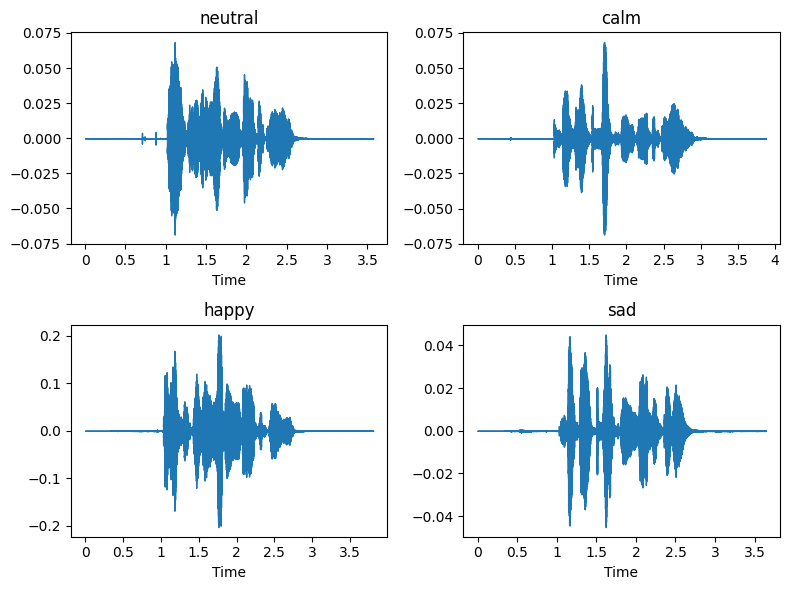

In [33]:
plot_speech_examples(plot_type='waveform')

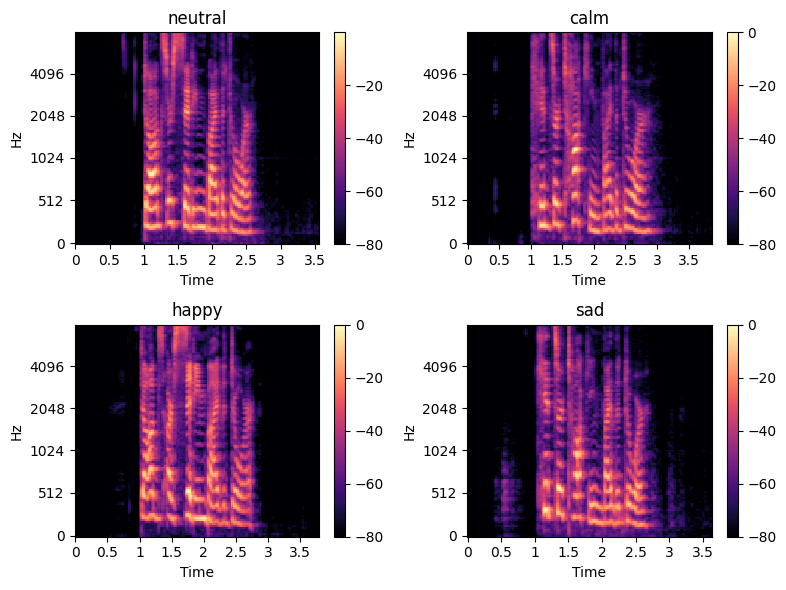

In [34]:
plot_speech_examples(plot_type='mel-spectrogram')

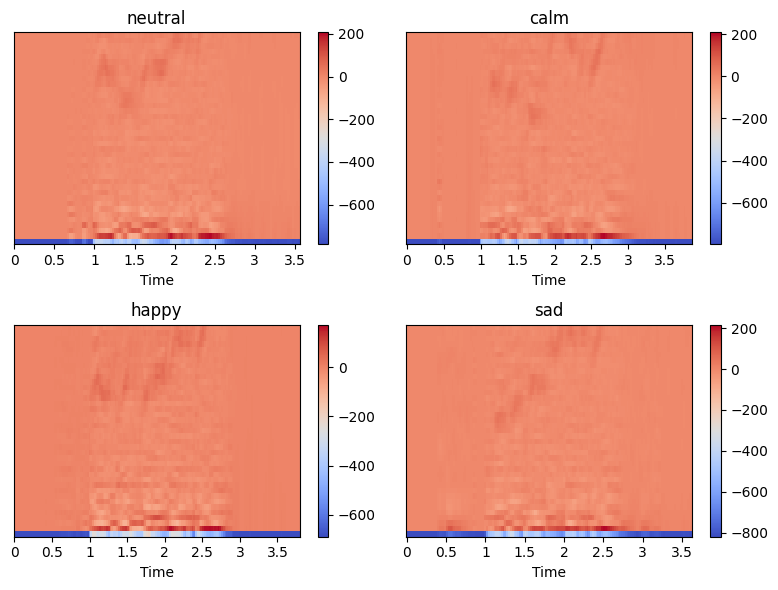

In [35]:
plot_speech_examples(plot_type='mfcc')

In [36]:
def feature_extraction_mfcc(file_path, mfcc_len=39, add_noise=False, mean_signal_length=110000):
    
    signal, sr = librosa.load(file_path)
    s_len = len(signal)

    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values = 0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    
    #add white noise to signals 
    if add_noise == True:
        noise = np.random.normal(0, 1, mean_signal_length)
        signal = signal + noise
        
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39)
    mfcc = mfcc.T
    feature = mfcc
    
    return feature

def generate_pickle_file(file_list, emotion_list, gender_list, dataset='RAVDESS', add_noise=False):
    
    def one_hot_encode(x, n_classes):
        return np.eye(n_classes)[x]
    
    if add_noise == False:
        
        feature_list = []
        
        for file in file_list:
            feature = feature_extraction_mfcc(file)
            feature_list.append(feature)
            
        assert len(feature_list) == len(emotion_list) == len(gender_list)
        feature_array = np.array(feature_list)
        emotion_array = np.array(emotion_list)
        gender_array = np.array(gender_list)
        emotion_array = one_hot_encode(emotion_array, len(np.unique(emotion_array)))
        gender_array = one_hot_encode(gender_array, len(gender_labels))
        
        data = {'feature': feature_array, 'emotion': emotion_array, 'gender': gender_array}
        save_name = 'clean_data.pickle'
        with open(save_name, 'wb') as f:
            pickle.dump(data, f)
        
    else:
        
        feature_list_with_noise = []
        emotion_list_with_noise = []
        gender_list_with_noise = []
        
        for i in range(len(emotion_list)):
            feature = feature_extraction_mfcc(file_list[i])
            feature_list_with_noise.append(feature)
            emotion_list_with_noise.append(emotion_list[i])
            gender_list_with_noise.append(gender_list[i])
            if emotion_list[i] == 0:
                feature = feature_extraction_mfcc(file_list[i], add_noise=True)
                feature_list_with_noise.append(feature)
                emotion_list_with_noise.append(emotion_list[i])
                gender_list_with_noise.append(gender_list[i])
        
        assert len(feature_list_with_noise) == len(emotion_list_with_noise) == len(gender_list_with_noise)
        feature_array = np.array(feature_list_with_noise)
        emotion_array = np.array(emotion_list_with_noise)
        gender_array = np.array(gender_list_with_noise)
        emotion_array = one_hot_encode(emotion_array, len(np.unique(emotion_array)))
        gender_array = one_hot_encode(gender_array, len(gender_labels))
        
        data = {'feature': feature_array, 'emotion': emotion_array, 'gender': gender_array}
        save_name = 'noise_data.pickle'
        with open(save_name, 'wb') as f:
            pickle.dump(data, f)
            
# generate_pickle_file(file_list, emotion_list, gender_list, add_noise=False)
# generate_pickle_file(file_list, emotion_list, gender_list, add_noise=True)